In [1]:
from pathlib import Path

from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
# define constants

DATA = Path.home() / 'devel/motiondetection'
DATA_ROOT = DATA / 'data'


In [3]:
print(DATA_ROOT)

/home/michele/devel/motiondetection/data


### Load data

**Data description**
- Column 1: Time in seconds
- Column 2: Acceleration reading in G for frontal axis
- Column 3: Acceleration reading in G for vertical axis
- Column 4: Acceleration reading in G for lateral axis
- Column 5: Id of antenna reading sensor
- Column 6: Received signal strength indicator (RSSI)
- Column 7: Phase
- Column 8: Frequency
- Column 9: Label of activity, 1: sit on bed, 2: sit on chair, 3: lying, 4: ambulating

In [4]:
dfs = []
activities = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in DATA_ROOT.rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activities[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    dfs.append(df)

activity_df = pd.concat(dfs, axis='index')
# activity_df.to_csv('activity_df.csv')

In [5]:
activity_df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant
0,0.000,0.037521,0.91636,-0.367180,2,-47.0,4.401000,923.25,4,ambulating,F,d1p26F
1,0.025,0.037521,0.91636,-0.367180,2,-47.0,4.158600,923.25,4,ambulating,F,d1p26F
2,0.075,0.037521,0.91636,-0.367180,2,-48.0,0.072097,923.25,4,ambulating,F,d1p26F
3,0.100,0.236850,1.05420,0.168760,2,-48.0,1.998800,923.25,4,ambulating,F,d1p26F
4,0.500,0.049247,1.00820,0.088944,2,-58.0,1.572300,921.25,4,ambulating,F,d1p26F


In [ ]:
len(activity_df.participant.unique())

In [36]:
participant = 'd1p43M'
df = activity_df[activity_df['participant'] == participant]
df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant
0,0.000,0.096148,0.90487,-0.002281,1,-49.5,2.4130,923.25,4,ambulating,M,d1p43M
1,0.025,0.096148,0.90487,-0.002281,1,-47.5,3.7429,922.25,4,ambulating,M,d1p43M
2,1.500,0.084423,0.83597,0.157360,2,-56.5,5.5898,920.25,4,ambulating,M,d1p43M
3,2.750,-0.396320,0.70966,0.134560,2,-57.0,4.8750,923.75,4,ambulating,M,d1p43M
4,3.500,-0.396320,0.70966,0.134560,2,-56.5,5.8966,922.75,4,ambulating,M,d1p43M


In [ ]:
part = df['participant'].unique()[0]

fig, ax = plt.subplots()
ax.plot(df['front'], color='aqua')
ax.plot(df['vertical'], color='blue')
ax.plot(df['lateral'], color='lime')
ax.set_title(part)

fig.savefig('{}.png'.format(part))


#### hmm it looks like some of the participants' data is very sparse. better get an indication of data points for each participant

In [ ]:
data_points = activity_df.groupby('participant').size()

In [ ]:
data_points.min()

In [ ]:
len(data_points[data_points < 100])

### let's plot the figure without lables for all the participants!

In [10]:
def plotter(name, group):
    fig, ax = plt.subplots()
    ax.plot(group['front'], color='aqua')
    ax.plot(group['vertical'], color='blue')
    ax.plot(group['lateral'], color='lime')
    ax.set_title(name)
    fig.savefig('{}.png'.format(name))
    plt.close(fig)

In [11]:
for name, group in activity_df.groupby('participant'):
    plotter(name, group)

### much neater way of creating gif from multiple plots:

(cheers Mark ;)

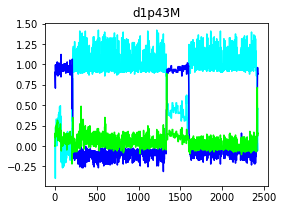

In [20]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(4, 3))
names = activity_df['participant'].unique()
    
def plotter(i):
    plt.cla()
    group = activity_df[activity_df['participant'] == names[i]]
    ax.plot(group['front'], color='aqua')
    ax.plot(group['vertical'], color='blue')
    ax.plot(group['lateral'], color='lime')
    ax.set_title(names[i])

# plotter is being passed to FuncAnimation and using frames to loop over the names
anim = FuncAnimation(fig, plotter, frames=np.arange(0, len(names)), interval=1000)
anim.save('plots.gif', dpi=150, writer='pillow')

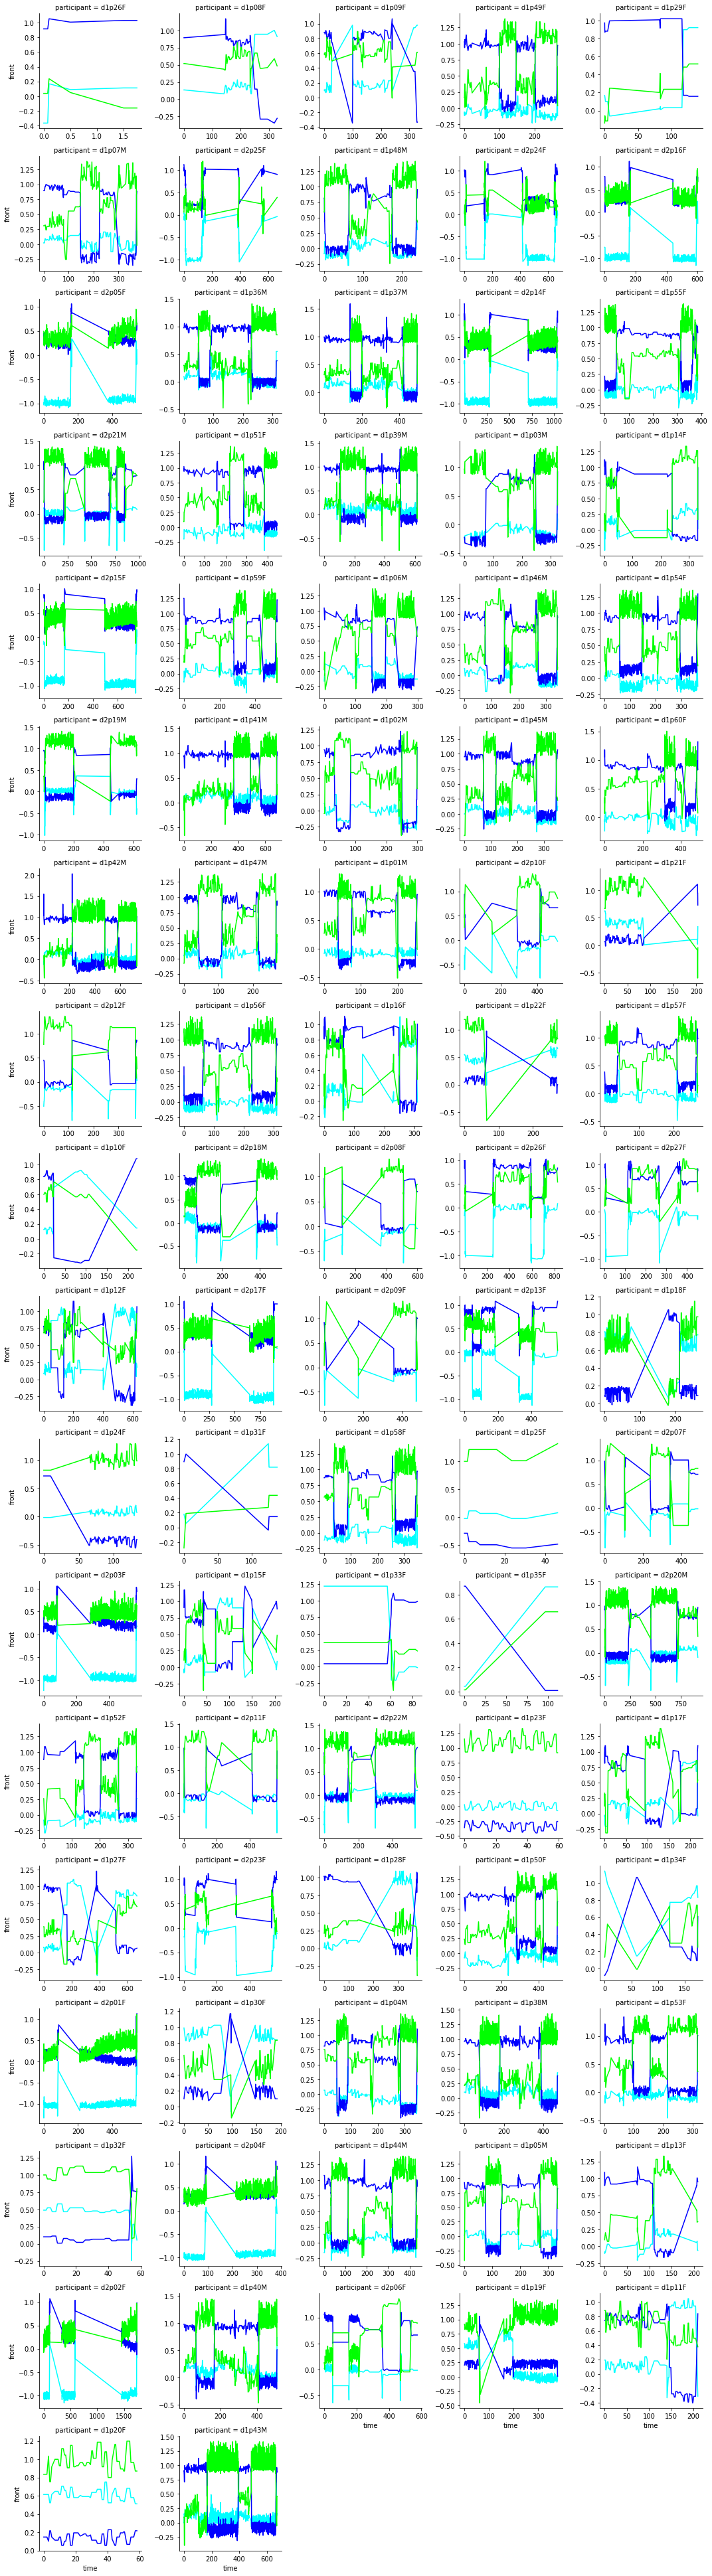

In [14]:
import seaborn as sns

g = sns.FacetGrid(activity_df, col='participant', col_wrap=5, sharex=False, sharey=False)

# explain how data gets passed to function here
def plotter(x, y, **kwargs):
    # need to get the axis in order to plot participant data
    ax = plt.gca()
    # data is a seaborn object which allows you to plot
    data = kwargs.pop('data')
    data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)
g.map_dataframe(plotter, 'time', 'lateral', color='aqua')
g.map_dataframe(plotter, 'time', 'vertical', color='blue')
g.map_dataframe(plotter, 'time', 'front', color='lime')

### making figures with lables for all the participants!

In [18]:
df.participant.unique()

array(['d1p43M'], dtype=object)

In [37]:
# find where the activities change 
transitions = np.where(df['activity'].values[:-1] != df['activity'].values[1:])[0]
start = 0
bounds = []
for end in transitions:
    bounds.append({
        'activity': df['activity'][start], 
        'activity_label': df['activity_label'][start], 
        'start_index': start, 
        'end_index': end,
        'start_time': df['time'][start],
        'end_time': df['time'][end]
    })
    start = end + 1
bound_df = pd.DataFrame(bounds)

In [38]:
bound_df

,activity,activity_label,start_index,end_index,start_time,end_time
0,4,ambulating,0,5,0.00,4.00
1,2,chair,6,71,5.75,102.00
2,4,ambulating,72,75,105.75,108.25
3,1,bed,76,212,109.25,168.00
4,3,lying,213,1330,168.25,391.25
5,1,bed,1331,1593,391.75,470.50
6,4,ambulating,1594,1597,471.75,473.25
7,1,bed,1598,1601,486.00,486.75
8,3,lying,1602,2411,487.00,663.63


#### fugly plot with arrows

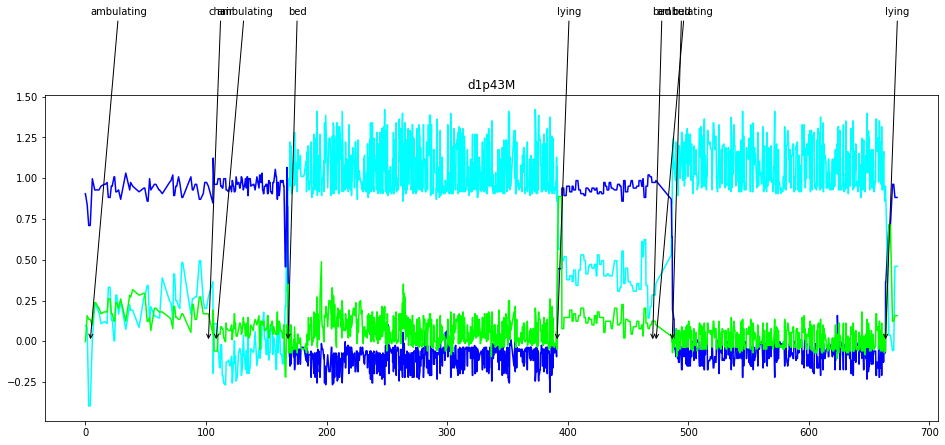

In [49]:
fig, ax = plt.subplots(figsize=(16, 6))
name = df['participant'].unique()[0]

plt.cla()
ax.plot(df['time'], df['front'], color='aqua', )
ax.plot(df['time'], df['vertical'], color='blue')
ax.plot(df['time'], df['lateral'], color='lime')
ax.set_title(name)


# fugly way of annotating:
for index, row in bound_df.iterrows():
    ax.annotate(row['activity_label'], xy=(row['end_time'], 0), xytext=(row['end_time'], 2), arrowprops=dict(arrowstyle="->"))

In [40]:
df.iloc[-1:]

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant
2426,673.25,0.45964,0.88191,0.15736,4,-59.0,5.4732,921.25,4,ambulating,M,d1p43M


### Rectangle above plots with demarcated start & end - labels to be inserted in a sensible way

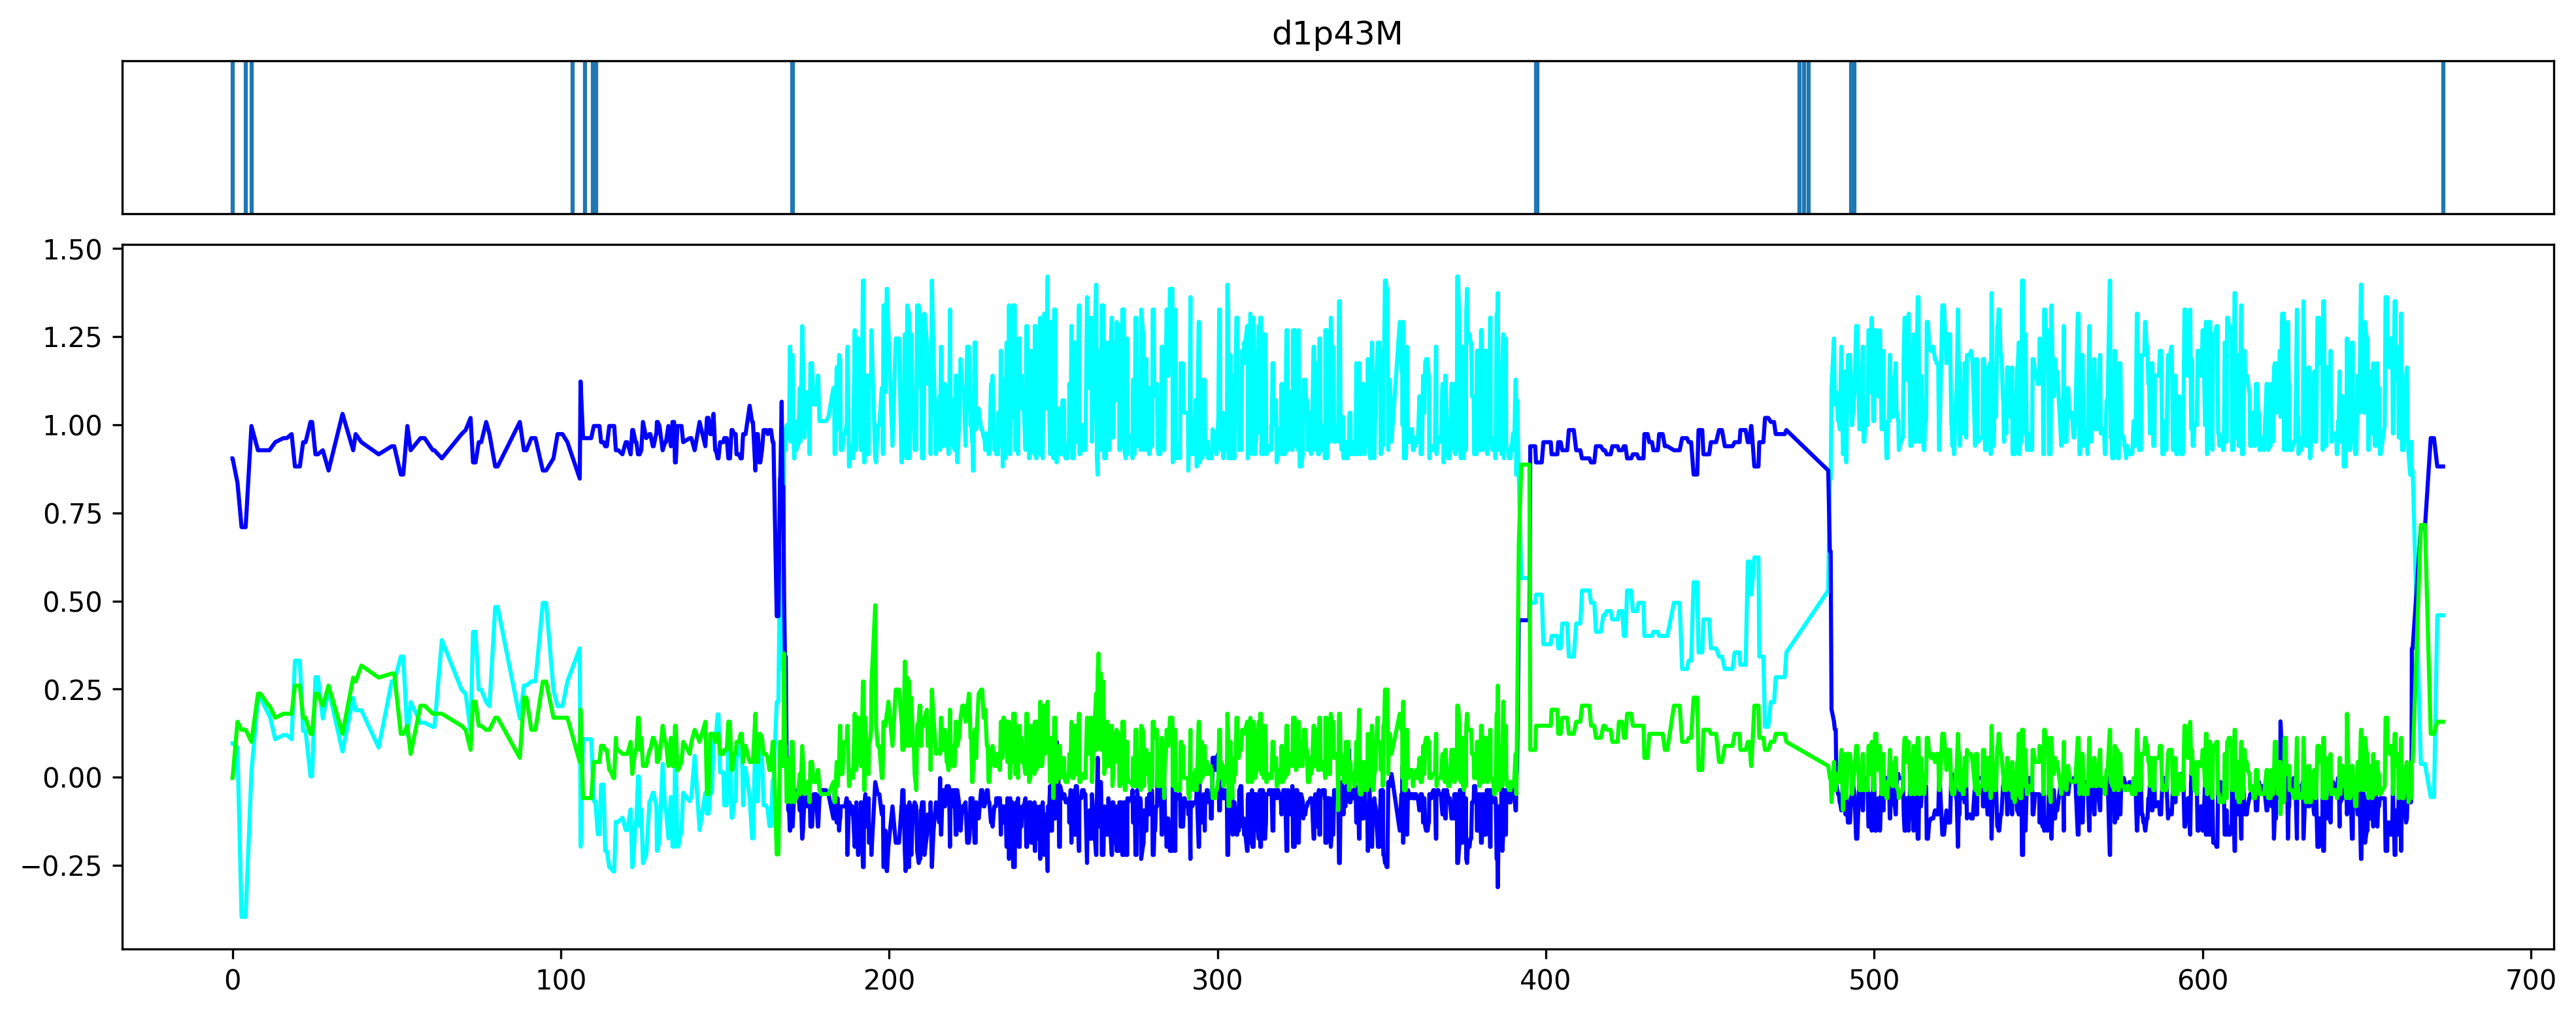

In [61]:

#plt.cla()
name = df['participant'].unique()[0]
fig = plt.figure(figsize=(16,6), dpi=300)

# do i really need this? better way of defining ax & ax_top?
gs = fig.add_gridspec(5, 1)

ax_top = fig.add_subplot(gs[0, :])
ax_top.set_xticks([])
ax_top.set_yticks([])
ax_top.set_title(name)

for index, row in bound_df.iterrows():
    ax_top.axvline(x=row['start_time'], ymin=0, ymax=1)
    ax_top.axvline(x=row['end_time'], ymin=0, ymax=1)

ax = fig.add_subplot(gs[1:, :])
ax.plot(df['time'], df['front'], color='aqua', )
ax.plot(df['time'], df['vertical'], color='blue')
ax.plot(df['time'], df['lateral'], color='lime')

